In [1]:
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
import cv2
import numpy as np
import dicom as pdicom
import os, sys
import subprocess as sp

In [3]:
import SimpleITK as sitk
import skimage.io as io

In [4]:
homeDir = "/home/seonwhee/Deep_Learning/Datasets/BRATS2015_Training/HGG/"
requestedPath = os.path.join(homeDir, 'brats_2013_pat0010_1')
mydatadir = os.path.realpath(requestedPath)
if not os.path.exists(mydatadir):
    print("The path %s does not exist" %(mydatadir))

In [5]:
MyFileURLs = {"T1": os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_T1.54567/VSD.Brain.XX.O.MR_T1.54567.mha'), 
              "T2": os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_T2.54569/VSD.Brain.XX.O.MR_T2.54569.mha'), 
              "FLAIR":os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_Flair.54566/VSD.Brain.XX.O.MR_Flair.54566.mha'), 
              "T1c": os.path.join(mydatadir, 'VSD.Brain.XX.O.MR_T1c.54568/VSD.Brain.XX.O.MR_T1c.54568.mha')}

In [6]:
img_T1 = sitk.ReadImage(MyFileURLs["T1"])
img_T2 = sitk.ReadImage(MyFileURLs["T2"])
img_FLAIR = sitk.ReadImage(MyFileURLs["FLAIR"])
img_T1c = sitk.ReadImage(MyFileURLs["T1c"])

## Image Smoothing/Denoising

In [5]:
img_T1_Smooth = sitk.CurvatureFlow(image1=img_T1, timeStep=0.125, numberOfIterations=5)
img_T2_Smooth = sitk.CurvatureFlow(image1=img_T2, timeStep=0.125,  numberOfIterations=5)
img_T1c_Smooth = sitk.CurvatureFlow(image1=img_T1c, timeStep=0.125, numberOfIterations=5)
img_FLAIR_Smooth = sitk.CurvatureFlow(image1=img_FLAIR, timeStep=0.125, numberOfIterations=5)

## Intensity Rescale

In [6]:
# To visualize the labels image in RGB with needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1_Smooth), sitk.sitkUInt8)
img_T2_255 = sitk.Cast(sitk.RescaleIntensity(img_T2_Smooth), sitk.sitkUInt8)
img_FLAIR_255 = sitk.Cast(sitk.RescaleIntensity(img_FLAIR_Smooth), sitk.sitkUInt8)
img_T1c_255 = sitk.Cast(sitk.RescaleIntensity(img_T1c_Smooth), sitk.sitkUInt8)

## Seed

In [8]:
# Slice index to visualize with 'sitk_show'
idxSlice = 77

# int label to assign to the segmented gray matter
labelGrayMatter = 1

lstSeeds = [(165, 178, idxSlice), (98, 165, idxSlice), (205, 125, idxSlice), (173, 205, idxSlice)]

In [9]:
imgGrayMatterT1 = sitk.ConfidenceConnected(image1=img_T1_Smooth, seedList=lstSeeds,
                                                numberOfIterations=3,multiplier=1, replaceValue=labelGrayMatter)
imgT1SmoothInt = sitk.Cast(sitk.RescaleIntensity(img_T1_Smooth), imgGrayMatterT1.GetPixelID())
imgGrayMatterT2 = sitk.ConfidenceConnected(image1=img_T2_Smooth, seedList=lstSeeds,
                                                numberOfIterations=3,multiplier=1, replaceValue=labelGrayMatter)
imgT2SmoothInt = sitk.Cast(sitk.RescaleIntensity(img_T2_Smooth), imgGrayMatterT2.GetPixelID())

## Intensity Non-uniformity Correction

In [ ]:
def applying_N3(inputList):
    output_dir = "/home/seonwhee/Radiology/N3_output/"
    command = "/home/seonwhee/Radiology/itkN3 %s %s" %(inputList, output_dir)
    sp.call(cmd)

## Image Registration using ANTs

In [7]:
from __future__ import print_function, unicode_literals
from builtins import open
from future import standard_library
standard_library.install_aliases()
import urllib.request
import urllib.error
import urllib.parse
from nipype.interfaces.ants import Registration

CompletedProcess(args='ls /home/seonwhee', returncode=0, stdout=b'anaconda3\nBioinformatics\nboost_1_55_0\nboost_1_55_0_lib\nboost_1_63_0\nC_coder\nchromedriver\ncuda_8.0.44_linux.run\ncuffData.db\nData_Mining\nDeep_Learning\nDesktop\nDocuments\nDownloads\nEigen\nexamples.desktop\nget-pip.py\nGoogle_DeepMind\ngsea_home\nhplip-3.16.11\nMathematics\nmatlab_R2016b\nMusic\nmxnet\nnode_modules\nNVIDIA_CUDA-8.0_Samples\nPictures\nprotobuf\nPublic\nQt5.6.0\nR\nRadiology\nrpudplus.LICENSE\nTemplates\ntensorflow\ntensors\nUdacity\nVideos\n')

In [25]:
reg = Registration()
reg.inputs.fixed_image = MyFileURLs["T1c"]
reg.inputs.moving_image = MyFileURLs["FLAIR"]
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'INTERNAL_WARPED.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3 +
                                   [[100, 50, 30]])
reg.inputs.dimension = 3
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['Mattes'] * 3 + [['Mattes', 'CC']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.01]
reg.inputs.convergence_window_size = [20] * 3 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 4
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 4
reg.inputs.use_histogram_matching = [False] * 3 + [True]
reg.inputs.initial_moving_transform_com = True


In [26]:
sp.run(reg.cmdline, shell=True, stdout=sp.PIPE)

CompletedProcess(args='antsRegistration --collapse-output-transforms 0 --dimensionality 3 --initial-moving-transform [ /home/seonwhee/Deep_Learning/Datasets/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_T1c.54568/VSD.Brain.XX.O.MR_T1c.54568.mha, /home/seonwhee/Deep_Learning/Datasets/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_Flair.54566/VSD.Brain.XX.O.MR_Flair.54566.mha, 1 ] --initialize-transforms-per-stage 0 --interpolation Linear --output [ output_, INTERNAL_WARPED.nii.gz ] --transform Translation[ 0.1 ] --metric Mattes[ /home/seonwhee/Deep_Learning/Datasets/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_T1c.54568/VSD.Brain.XX.O.MR_T1c.54568.mha, /home/seonwhee/Deep_Learning/Datasets/BRATS2015_Training/HGG/brats_2013_pat0010_1/VSD.Brain.XX.O.MR_Flair.54566/VSD.Brain.XX.O.MR_Flair.54566.mha, 1, 32, Regular, 0.3 ] --convergence [ 10000x111110x11110, 1e-08, 20 ] --smoothing-sigmas 4.0x2.0x1.0vox --shrink-factors 6x4x2 --use-estimate-lea

In [ ]:
reg.run()

## Visualization

In [10]:
from ipywidgets import interact, FloatSlider
from myshow import myshow, myshow3d
from image_detector import sitk_show, sitk_tile_vec, read_image_into_ndArray

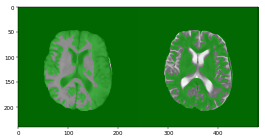

In [11]:
sitk_tile_vec([sitk.LabelOverlay(imgT1SmoothInt[:,:,idxSlice], imgGrayMatterT1[:,:,idxSlice]),
               sitk.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], imgGrayMatterT2[:,:,idxSlice])])

In [14]:
myshow3d(imgComp)
myshow3d(imgGrayMatterComp)

A Jupyter Widget

A Jupyter Widget

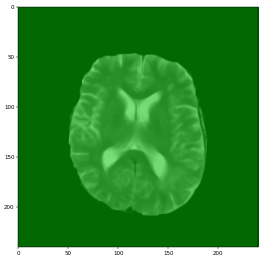

In [15]:
sitk_show(sitk.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], imgGrayMatterComp[:,:,idxSlice]))

## Save 3D image Files

In [ ]:
sitk.WriteImage(imgGrayMatterComp, "./GrayMatter.mha")

In [ ]:
def get_image_info(imgObject):
    imgDict = {}
    imgDict["Dimension"] = imgObject.GetDimension()
    imgDict["Size"] = imgObject.GetSize()
    imgDict["Num_Pixels"] = imgObject.GetNumberOfPixels()
    return imgDict

In [ ]:
haha = get_image_info(imgComp)
print(haha)